# Quantum Distance Based Classifier

#### Follows the implementation of the Quantum Distance Based Classifier by Schuld, Fingerhuth and Petruccione
#### For more details: https://arxiv.org/abs/1703.10793 [1]

#### To prevent inconsistencies, I have to notice you that in [1], the circuit starts by superposing both |a> and |m>.  In my circuit, I decided to postpone the application of H on |m> for an illustrative purpose. However, this difference doesn't affect in any way the computation.

In [14]:
import qiskit
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, Aer
from qiskit.extensions import Initialize, UnitaryGate
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city
from qiskit_textbook.tools import random_state, array_to_latex
from utility import qdrawer

from qiskit.circuit.library import CPhaseGate,CU1Gate, CRXGate

from numpy import pi

## Quantum Circuit

In [17]:
class QDistanceBasedClassifier:
    
####################################################################
    def get_circuit(self):
        return self.qc
        
####################################################################
        
    def _step_A(self, a):
        '''Uniform superpos of ancilla and index qubit'''
        self.qc.h(a)
        self.qc.barrier()

####################################################################

    def _step_B(self, alpha, a, b, c):
        '''Loading test vector  '''
        self.qc.mcry(alpha, a, c[0], None) 
        self.qc.barrier()
        self.qc.x(a)
        self.qc.barrier()
        self.qc.h(b)
        self.qc.barrier()

        
####################################################################

    def _step_C(self, alpha, a, b, c, d):
        '''Loading first training vector'''
        self.qc.mcry(alpha, a[0:]+b[0:], c[0], None) 
        self.qc.barrier()
        self.qc.cx(b, d)
        self.qc.barrier()

####################################################################
        
    def _step_D(self, alpha, a, b, c, d):
        '''Load second training vector'''
        self.qc.mcry(alpha, a[0:]+b[0:], c[0], None) 
        self.qc.barrier()
        self.qc.cx(b, d)
        self.qc.barrier()
        
####################################################################

    def _step_F(self, a):
        '''Compute distance'''
        self.qc.h(a)
        self.qc.barrier()
        
        
####################################################################

    def _step_E(self, cqr, counting_qr):
        '''Estimates'''
        
        
        self.qc.h(counting_qr)
        theta = 2*pi*1/4

        #Insert control test --> test |0> is correct
        self.qc.x(cqr)
        
        for i in range(len(counting_qr)):
            self.qc.append(CPhaseGate(theta*(2**i)), [cqr[0], counting_qr[i]])
            
        self.qc.x(cqr)
        self.qc.barrier()
        
        #----- Inverse QFT -----#
        for i in range(math.floor(len(counting_qr)/2)):
            if i != len(counting_qr)-i-1:
                self.qc.swap(counting_qr[i], counting_qr[len(counting_qr)-i-1])

               
        for i in range(len(counting_qr)):
            for j in range(i):
                cu1gate = CU1Gate(-pi/(2**(i-j)))
                self.qc.append(cu1gate, [counting_qr[j], counting_qr[i]])
            self.qc.h(counting_qr[i])
            self.qc.barrier()
        
####################################################################

    def step_measure(self, counting_qr, c_acc, aqr, c_areg):
        '''Measurements'''
        self.qc.measure(counting_qr, c_acc)
        self.qc.measure(aqr, c_areg)

        
        
####################################################################

    def _init_qc(self, precision):
        aqr = QuantumRegister(1, name="ancilla ")
        mqr = QuantumRegister(1, name="index qregister ") #Just one since we have only two training inputs
        iqr = QuantumRegister(1, name="data register ")
        cqr = QuantumRegister(1, name="classes ")

        #Accuracy
        c_areg = ClassicalRegister(1, name="classical ancilla ")
        counting_qr = QuantumRegister(precision, name="precision ")
        c_acc = ClassicalRegister(precision, name="classical acc")

        
        qc = QuantumCircuit(aqr, mqr, iqr, cqr, counting_qr, c_areg, c_acc)
        return qc, aqr, mqr, iqr, cqr, counting_qr, c_acc, c_areg
    
####################################################################

    def __init__(self, alpha_tr_1, alpha_test, precision):
        self.qc, self.aqr, self.mqr, self.iqr, self.cqr, self.counting_qr, self.c_acc, self.c_areg = self._init_qc(precision)
        
        #Uniform superpos of ancilla and index qubits
        self._step_A(self.aqr)

        #Loading test vector
        self._step_B(alpha_test, self.aqr, self.mqr, self.iqr)

        #Loading first training vector
        self._step_C(alpha_tr_1, self.aqr, self.mqr, self.iqr, self.cqr)

        #Load second training vector
        self._step_D(alpha_tr_1, self.aqr, self.mqr, self.iqr, self.cqr)

        #compute distance
        self._step_F(self.aqr)
        
        #Estimates
        self._step_E(self.cqr, self.counting_qr)
        
        #Measurements
        self.step_measure(self.counting_qr, self.c_acc, self.aqr, self.c_areg)     

####################################################################

# MAIN

### Load Circuit

In [18]:
#Follows the paper's inputs

test_1 = [-0.549, 0.836]   
tr_0 = [0,1] 
tr_1 = [0.789, 0.615]


#Computing the rotation angle
alpha_test = np.arctan2(test_1[1], test_1[0])*2
alpha_tr_1 = np.arctan2(tr_1[1], tr_1[0])*2
print("Test Vector's alpha:", alpha_test)
print("Training_1 Vector's alpha:", alpha_tr_1)
#using arcatan2 --> Obtain the correct quadrans. Otherwise, with arctan(y/x) you cannot get the correct quadrant
#ex: -1.52 can be obtained from (-y/x) and (y/-x)

precision = 3
q_distance_based_classifier = QDistanceBasedClassifier(alpha_tr_1, alpha_test, precision)

Test Vector's alpha: 4.30373230357443
Training_1 Vector's alpha: 1.3241904926325558


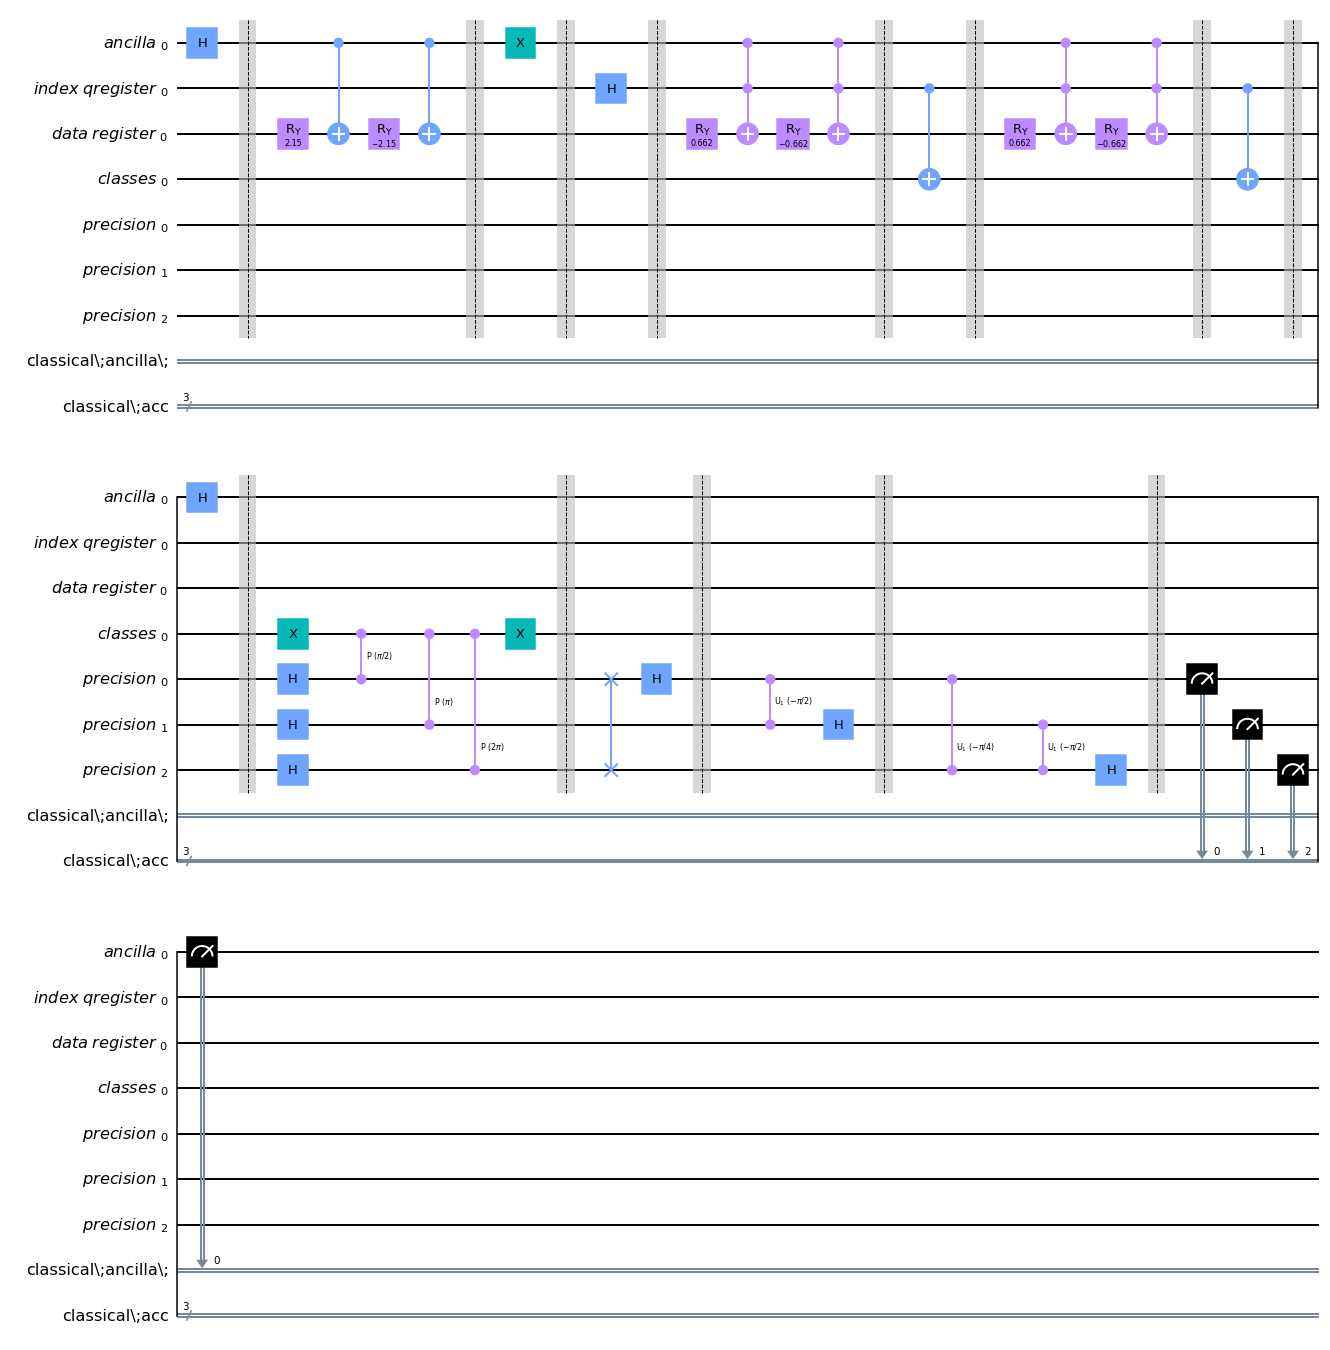

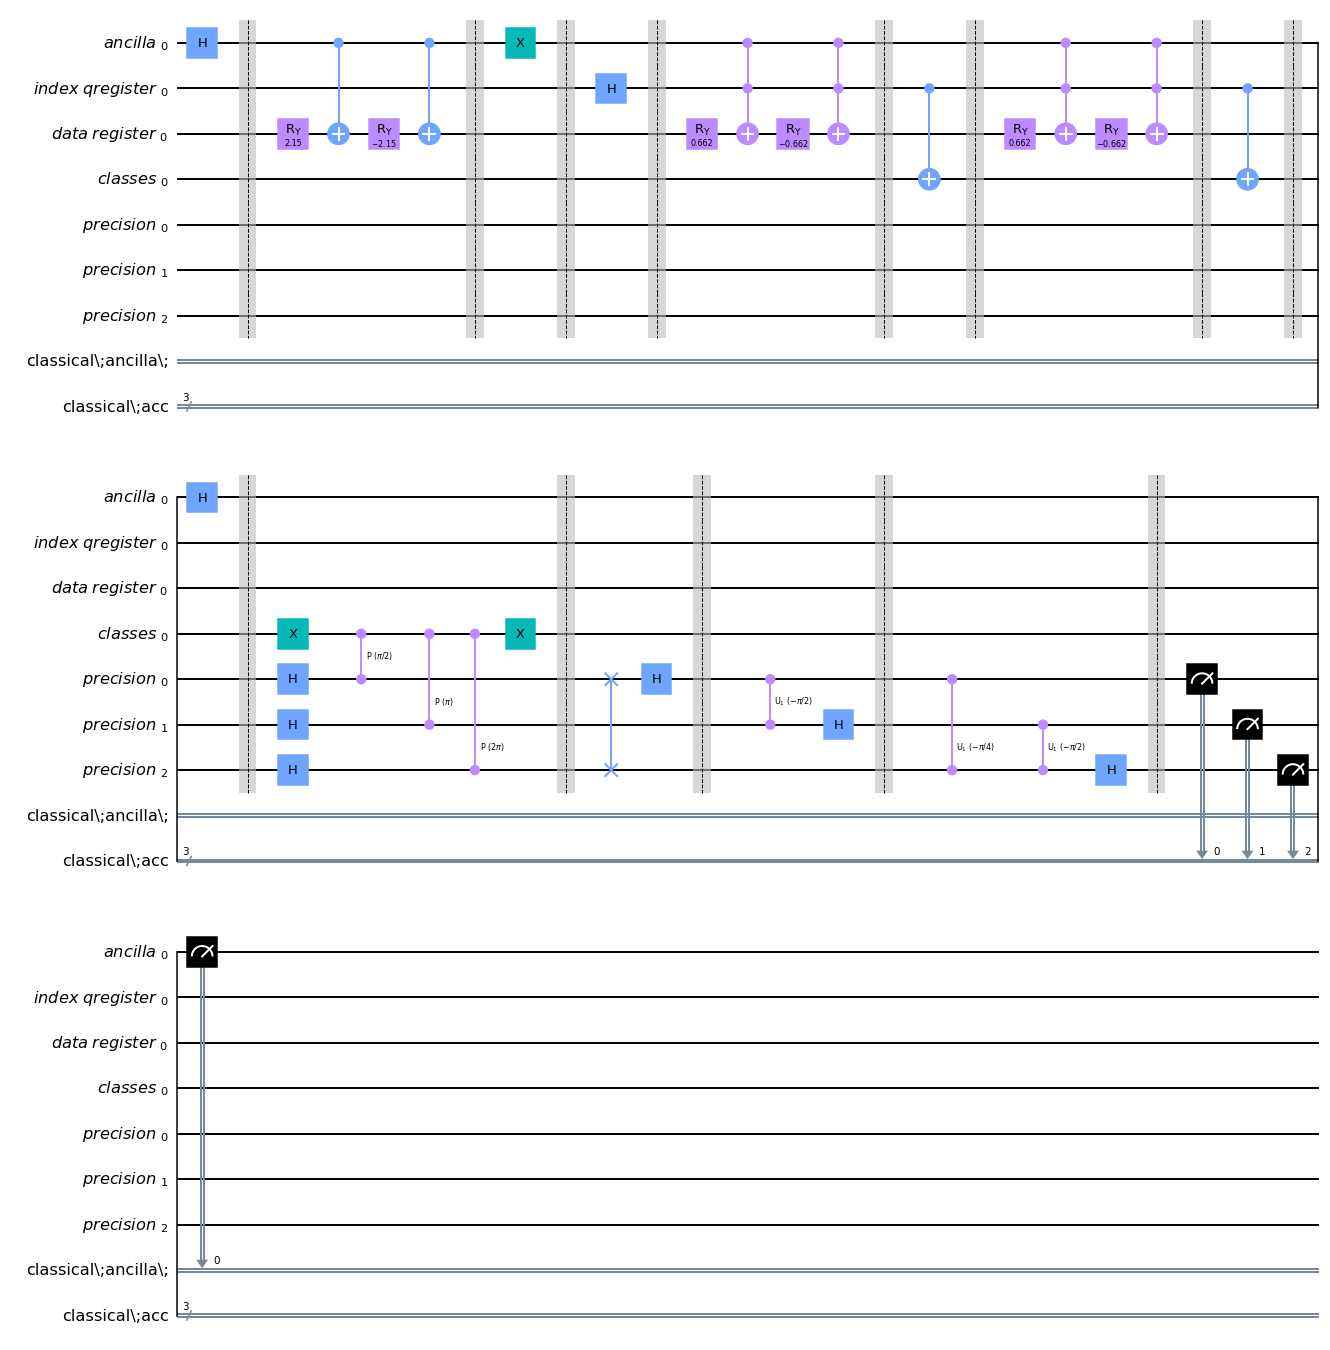

In [19]:
q_distance_based_circuit = q_distance_based_classifier.get_circuit()
q_distance_based_circuit.draw()

## Plotting Dataset (Unitary circle)

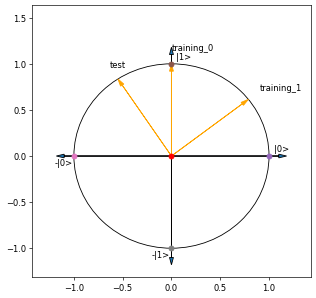

In [20]:
qdrawer.draw_qubit()
qdrawer.draw_quantum_state(test_1[0],test_1[1],"test", color='orange')
qdrawer.draw_quantum_state(tr_1[0],tr_1[1],"training_1", color='orange')
qdrawer.draw_quantum_state(0, 1,"training_0", color='orange')

# Simulation

010
Estimated K: 1.0
Estimated Phase:  0.25
{'010 0': 2166}


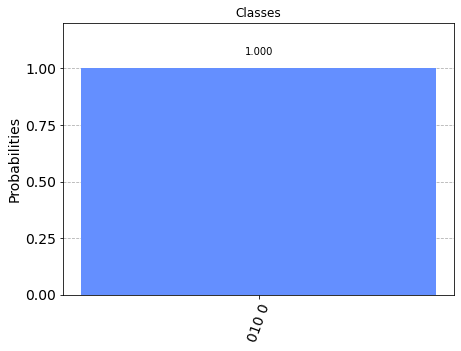

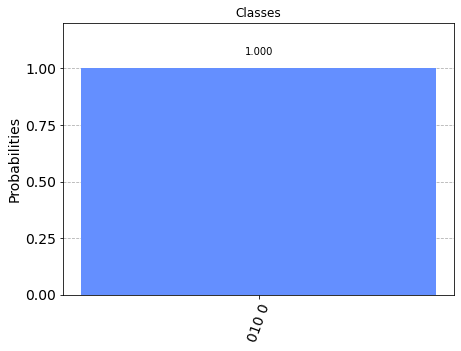

In [22]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(q_distance_based_circuit, simulator, shots=4096)
counts = job.result().get_counts()
#counts = result.get_counts(q_distance_based_circuit)
a = counts.most_frequent()[0:precision]
print(a)

bin_a = int(a,2) #Converts the binary value to an integer
phase = bin_a/(2**precision) #The calculation used to estimate the phase
estimated_k = bin_a*2*pi/((2**precision)*2*pi*1/4)

print("Estimated K:", estimated_k)
print("Estimated Phase: ", phase)
#print("Actual K: ", k)

post_select = lambda counts: [(state, occurences) for state, occurences in counts.items() if state[-1] == '0']
postselection = dict(post_select(counts))
print(postselection)
plot_histogram(postselection, title="Classes")

# Devo fare comunque gli shots. Duplicare tante volte lo stesso test? In questo modo evito di dover fare molti shot.
# In sostanza uso il counting come metro per dirmi quante volte, da uno stesso circuito con la
# qram duplicata è uscita

### On x axis, the highest bit indicates the output class. So:
#### 00 --> test vector belongs to class 0
#### 10 --> test vector belongs to class 1